In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd.plotter import plot_eigs, plot_summary

from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency

# Loading the (time series) data

In [2]:
_  = pd.read_csv('cdii.csv').drop(columns=['Unnamed: 0'])
Xn = _.values

t=np.linspace(0,230,24)

# Setting up the _thresholding function_

In [3]:
def hard_threshold(X, gamma=0.01):
    # Hard thresholding for L0 norm.
    X[np.abs(X) ** 2 < 2 * gamma] = 0.0
    return X

# Generating the $H_{0,i}$ model 
Where $i$ is a generic gene among the 1807 tracked

In [20]:
## This code will run for several minutes (30 on an Apple M2)
N = 1000
As = np.empty((1807, 1807, N))
del As

As = np.empty((1807, 1807, N))

for i in trange(N):

    bopdmd = BOPDMD(
    svd_rank=24,
    num_trials=0,
    trial_size=0.8,
    varpro_opts_dict={"verbose":False, "tol":0.8},
    eig_constraints={"imag"},
    use_proj=False,
    mode_proxy=hard_threshold, 
    compute_A=True
    )   
    perm = np.random.permutation(Xn.shape[1])
       
    bopdmd.fit(Xn[:, perm], t)
    
    As[:,:,i] = deepcopy(bopdmd.A)
    # As[:,:,i] = np.random.rand(1807, 1807)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/fmenol/miniconda3/envs/dmd/lib/python3.8/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 2560114641845766.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/var/folders/sg/6fb84wgs1cz_lnnmvn_x3qvm0000gn/T/ipykernel_66226/2010145635.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  As[:,:,i] = deepcopy(bopdmd.A)
  0%|          | 1/1000 [00:04<1:07:56,  4.08s/it]/Users/fmenol/miniconda3/envs/dmd/lib/python3.8/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 2523826487460931.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
  0%|          | 2/1000 [00:10<1:27:56,  5.29s/it]/Users/fmenol/miniconda3/envs/dmd/lib/python3.8/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 2428767584175753.5. Consider preprocessing data, passing in augmented data
ma

# Visualise the empirical PDF of the null model of a random gene

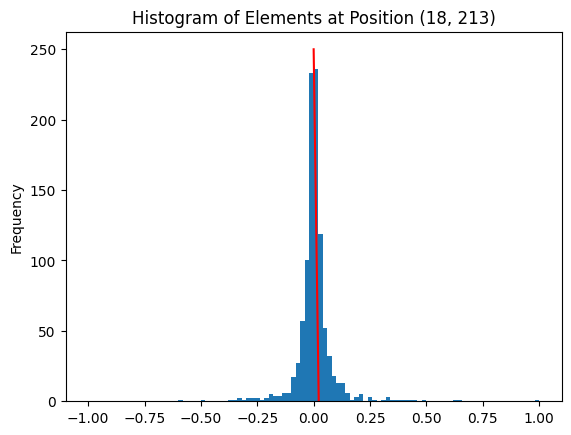

In [45]:

# Plot the histogram
plt.hist(As[57,12,:].flatten(), bins=100, range=(-1, 1))
plt.plot([np.real(A[57,12]),0], [0, 250], color='red')

plt.ylabel('Frequency')
plt.title('Histogram of Elements at Position (18, 213)')
plt.show()

# Infer the network connectivity using BOPDMD

In [22]:
bopdmd = BOPDMD(
svd_rank=24,
num_trials=0,
trial_size=0.8,
varpro_opts_dict={"verbose":False, "tol":0.8},
eig_constraints={"imag"},
use_proj=False,
mode_proxy=hard_threshold,
compute_A=True
)


bopdmd.fit(Xn, t)
A = bopdmd.A

/Users/fmenol/miniconda3/envs/dmd/lib/python3.8/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 2615289798513474.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


# Create a matrix with _statistically significant_ links

In [29]:
Asig = np.empty((1807,1807))

# Iterate through each element in A
for i in trange(A.shape[0]):
    for j in range(A.shape[1]):
        # Extract the distribution for the current element from As
        distribution = As[i, j, :]

        # Calculate the 5th and 95th percentiles of the distribution
        p5 = np.percentile(distribution, 5)
        p95 = np.percentile(distribution, 95)

        # Check if A[i, j] is in the first or last 5th percentile
        if A[i, j] <= p5 or A[i, j] >= p95:
            Asig[i, j] = 1

100%|██████████| 1807/1807 [06:17<00:00,  4.78it/s]


In [30]:
# Loading the "ground truth" A matrix
gene_mat = pd.read_csv('./data/gene_matrix_1807.csv', index_col=0) 
Atrue_ = gene_mat.values
Atrue =np.abs(Atrue_)

# Deriving the confusion matrix

In [31]:
c=confusion_matrix(Atrue.flatten(), Asig.flatten())

# Calculating the p-value from the confusion matrix

In [32]:
chi2, p_value, _, _ = chi2_contingency(c)

print("Chi-squared statistics:", chi2)
print("p-value:", p_value)

Chi-squared statistics: 0.008140846256542794
p-value: 0.9281071163633058


In [33]:
c

array([[3199990,   64794],
       [    455,      10]])